# EDA #

** Data Import **

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
train_data = pd.read_csv('./data/madelon_train.data', 
                         sep = ' ', header = None).drop(500, axis = 1)

In [3]:
train_labels = pd.read_csv('./data/madelon_train.labels', sep = ' ', header = None)

In [4]:
train_data.shape

(2000, 500)

In [5]:
train_labels.shape

(2000, 1)

In [6]:
val_data = pd.read_csv('./data/madelon_valid.data', 
                         sep = ' ', header = None).drop(500, axis = 1)
val_labels = pd.read_csv('./data/madelon_valid.labels', sep = ' ', header = None)

In [7]:
val_data.shape

(600, 500)

In [8]:
val_labels.shape

(600, 1)

In [9]:
test_data = pd.read_csv('./data/madelon_test.data', 
                         sep = ' ', header = None).drop(500, axis = 1)

** Data merge **
Do we want to do this?

In [10]:
train_data['target'] = train_labels

In [11]:
val_data['target'] = val_labels

In [12]:
df = train_data.append(val_data)

In [13]:
train_data.shape

(2000, 501)

In [14]:
val_data.shape

(600, 501)

In [15]:
df.shape

(2600, 501)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2600 entries, 0 to 599
Columns: 501 entries, 0 to target
dtypes: int64(501)
memory usage: 10.0 MB


In [17]:
df.get_dtype_counts()

int64    501
dtype: int64

# Step 1 - Benchmarking #

** Subsetting **

In [18]:
sub1 = df.sample((int(.1*(len(df)))), random_state = 22)

In [19]:
sub1.shape

(260, 501)

In [20]:
sub2 = df.sample((int(.1*(len(df)))), random_state = 8)

In [21]:
sub2.shape

(260, 501)

In [22]:
sub3 = df.sample((int(.1*(len(df)))), random_state = 10)

In [23]:
sub3.shape

(260, 501)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c5803b2e8>]], dtype=object)

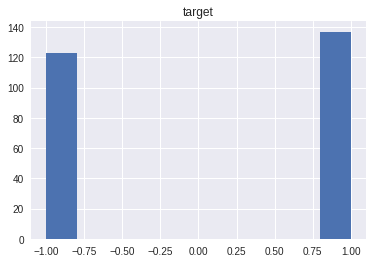

In [24]:
sub1.hist(column = 'target')

In [25]:
base_neg1 = 123/260

In [26]:
base_pos1 = 137/260

In [27]:
df['target'].value_counts()

 1    1300
-1    1300
Name: target, dtype: int64

In [28]:
predictors = df[df.columns[0:500]]
target = df[df.columns[500]]

In [29]:
predictors.shape

(2600, 500)

In [30]:
target.shape

(2600,)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = .2, random_state = 42)

In [32]:
X_train_bc = pd.DataFrame()
X_test_bc = pd.DataFrame()
for col in X_train.columns:
    box_cox_trans_train, lmbda = boxcox(X_train[col])
    box_cox_trans_test = boxcox(X_test[col], lmbda)
    X_train_bc[col] = pd.Series(box_cox_trans_train)
    X_test_bc[col] = pd.Series(box_cox_trans_test)

/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:901: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1855: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1849: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


ValueError: Data must be positive.

**Logistic Regression**

In [34]:
scaler = StandardScaler()
lr = LogisticRegression(C = 10000)
sfm = SelectFromModel(lr, threshold = 'mean')
lr_benchmark = LogisticRegression(C = 10000)
pipe_lr = Pipeline([
    ('scaler', scaler),  
    ('sfm', sfm), 
    ('lr_benchmark', lr_benchmark)
])

In [35]:
pipe_lr.fit_transform(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 1.57369128,  0.39808295, -0.97882427, ..., -0.03262612,
         2.08671436,  0.42822125],
       [-0.32840624,  1.15684153, -1.61511896, ..., -0.27964317,
         1.12603434,  0.44375532],
       [ 0.97058719, -0.77454394,  0.97719275, ..., -0.18981879,
        -0.75473359,  1.10395325],
       ..., 
       [ 0.04273474, -0.63658783,  0.03453394, ...,  1.09017868,
        -1.0794705 ,  1.91949186],
       [-0.60676197,  0.81195127,  0.67082864, ..., -1.55964063,
         0.81482814, -0.70576577],
       [-1.58100704, -0.22271952, -0.27183017, ...,  0.50632018,
        -2.04015053,  2.26900841]])

In [36]:
accuracy_score(y_test, pipe_lr.predict(X_test))

0.53653846153846152

Predicted 1 or -1 with 58% accuracy

In [37]:
roc_auc_score(y_test, pipe_lr.predict(X_test))

0.5368096344187836

In [38]:
print(classification_report(y_test, pipe_lr.predict(X_test)))

             precision    recall  f1-score   support

         -1       0.54      0.51      0.53       263
          1       0.53      0.56      0.54       257

avg / total       0.54      0.54      0.54       520



**Decision Tree**

In [39]:
# !pip install pydotplus pydot2
# import pydotplus
# from sklearn.tree import export_graphviz

In [40]:
dt_benchmark = DecisionTreeClassifier()
pipe_dt = Pipeline([
    ('scaler', scaler),  
    ('sfm', sfm), 
    ('dt_benchmark', dt_benchmark)
])

In [41]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])

In [42]:
accuracy_score(y_test, pipe_dt.predict(X_test))

0.77307692307692311

In [43]:
print(roc_auc_score(y_test, pipe_dt.predict(X_test)))
print(classification_report(y_test, pipe_dt.predict(X_test)))

0.773313015046
             precision    recall  f1-score   support

         -1       0.79      0.75      0.77       263
          1       0.76      0.79      0.78       257

avg / total       0.77      0.77      0.77       520



In [44]:
# From CART lesson in week 6, reference if you want to visualize this decision tree

# dot_data = StringIO()  

# export_graphviz(
#     model, 
#     out_file = dot_data,  
#     filled=True, rounded=True, proportion=False,
#     special_characters=True, 
#     feature_names=food_encoded.columns,
#     class_names=["Bacon", "Vegetable"]
# )  

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

# Image(graph.create_png()) 

**K Nearest Neighbor**

In [45]:
knn_benchmark = KNeighborsClassifier(n_neighbors = 5)
pipe_knn = Pipeline([
    ('scaler', scaler),  
    ('sfm', sfm), 
    ('knn_benchmark', knn_benchmark)
])

In [46]:
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [47]:
accuracy_score(y_test, pipe_knn.predict(X_test))

0.62307692307692308

In [48]:
print(roc_auc_score(y_test, pipe_knn.predict(X_test)))
print(classification_report(y_test, pipe_knn.predict(X_test)))

0.623293041973
             precision    recall  f1-score   support

         -1       0.63      0.60      0.62       263
          1       0.61      0.64      0.63       257

avg / total       0.62      0.62      0.62       520



Scratch work below

In [ ]:
Xs_train_bc = scaler.fit_transform(X_train_bc, y_train)

In [ ]:
X_transformed = sfm.fit_transform(Xs_train_bc, y_train)

In [ ]:
X_transformed.shape

With high C, 182 noisey features remain. As a benchmark (almost 0 C), 185 noisey features remain. With boxcox deskew, we remove 9 more noisey features, leaving 176 left.

In [ ]:
np.sum(sfm.get_support())

In [ ]:
len(sfm_feats)

In [ ]:
sfm_feats = np.where(sfm.get_support())[0]
sfm_feats

In [ ]:
Xs_train_slim = pd.DataFrame(columns = sfm_feats)

In [ ]:
for i in sfm_feats:
    Xs_train_slim[i] = Xs_train_bc[:,i]

In [ ]:
Xs_train_slim.sample(2)

In [ ]:
CLF = LogisticRegression(C = 10000)

In [ ]:
CLF.fit_transform(Xs_train_slim, y_train)

In [ ]:
CLF.transform(X_test_bc)

In [ ]:
CLF.transform(X_test)

In [ ]:
# pipe = Pipeline([
#     ('scaler', scaler()),
#     ('sfm', sfm()),
    
# ])